### Load necessary libraries

In [6]:
import pandas as pd

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  RandomizedSearchCV  , GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer ,TfidfTransformer

from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.metrics import make_scorer, roc_auc_score


from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


### Load Data 


In [7]:
df = pd.read_csv("intent_data.csv", encoding = "utf8", sep='\t',names = ["txt", "Intent"])
df.head()

,txt,Intent
0,- Bakabileceğim bazı dersler var mı?,ask_faq_tutorials
1,- dersleriniz var mı,ask_faq_tutorials
2,- ciftci_bot'un nasıl kullanılacağı hakkında b...,ask_faq_tutorials
3,- ciftci_bot eğitimi,ask_faq_tutorials
4,- bana öğretici gösterebilir misin,ask_faq_tutorials


### Perform pre processing and text cleaning

In [8]:
df['txt'] = df['txt'].str.replace(r'([,-.])', ' ' )
df['txt'] = df['txt'].str.lower()
df['txt'] = df['txt'].str.replace(r'([!?()@])', r' \1 ')

In [9]:
# check some of the results
df.iloc[572]


txt         elise @ gmail com
Intent             enter_data
Name: 572, dtype: object

### Becoming more familiar with distribution of classes in the dataset

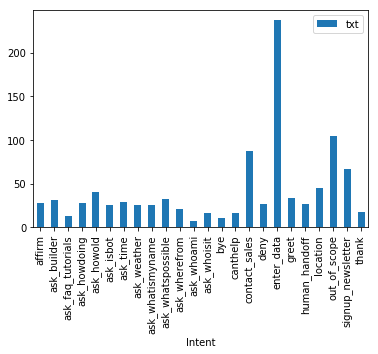

In [5]:
fig = plt.figure(figsize=(10,10))
df.groupby('Intent').count().plot.bar(ylim=0)
plt.show()

### Load  Turkish Stop Words to user later :  Türkçe Dolgu Sözcükleri

In [6]:
stopWordFile = open("turkce-stop-words",encoding="utf-8")

tuStopWords = []
for word in stopWordFile:
    word = word.strip()
    tuStopWords.append(word)

tuStopWords[:5]

['a', 'acaba', 'altı', 'altmış', 'ama']

## Classical ML techniques

### Constructing a list of usual text classifiers to compare their accuracy and choose one

In [7]:
models = [
    RandomForestClassifier(n_estimators=20, max_depth=4, random_state=0 ,n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

### Split and transform our text into TF_IDF vectors

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['txt'], df['Intent'], random_state = 0 ,stratify =df['Intent'])

count_vect = CountVectorizer(stop_words=tuStopWords ,ngram_range =(1,2),min_df=2, encoding='utf8')

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)

X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)




### Search for the best classifier

In [9]:
reports = []

for model in models:
    
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, y_train, scoring='accuracy', cv=5)
    reports.append((model_name, np.mean( accuracies)))

reports.sort()    
pprint(reports)

[('LinearSVC', 0.6512431130513321),
 ('LogisticRegression', 0.48478566361563946),
 ('MultinomialNB', 0.40462987527290506),
 ('RandomForestClassifier', 0.3275653038876246)]


### Choosing LinearSVC and perform hyperparameter tuning with randomized search

In [10]:
clf = LinearSVC(multi_class="ovr")


grid_list = {"C": [0.001, 0.01, 0.1, 1, 10],
             }
grid_search = GridSearchCV(clf, param_grid = grid_list, n_jobs = -1, cv = 3) 
grid_search.fit(X_train_tfidf, y_train) 


print("best_params : ",grid_search.best_params_)
print("best_score : ",grid_search.best_score_)

best_params :  {'C': 1}
best_score :  0.6442953020134228


###  Training the model

In [11]:
clf = LinearSVC(C=1.0)
clf.fit(X_train_tfidf, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

###  Getting Base score on test set

In [12]:
clf.score(X_test_tfidf , y_test)

0.642570281124498

###  Getting Predictions on  test set

In [13]:
y_pred = clf.predict(X_test_tfidf)

###  Getting classification report

In [14]:
print(classification_report(y_test, y_pred, target_names=df['Intent'].unique()))

                   precision    recall  f1-score   support

ask_faq_tutorials       0.80      0.57      0.67         7
       ask_howold       1.00      0.12      0.22         8
        ask_isbot       0.25      0.33      0.29         3
         ask_time       0.83      0.71      0.77         7
 ask_whatismyname       1.00      1.00      1.00        10
    ask_wherefrom       0.38      0.50      0.43         6
       ask_whoami       0.88      1.00      0.93         7
      ask_builder       0.75      1.00      0.86         6
     ask_howdoing       1.00      0.57      0.73         7
      ask_weather       0.56      0.62      0.59         8
ask_whatspossible       1.00      0.40      0.57         5
      ask_whoisit       0.00      0.00      0.00         2
              bye       0.50      0.25      0.33         4
         canthelp       1.00      1.00      1.00         3
    contact_sales       0.50      0.25      0.33         4
             deny       0.74      0.77      0.76       

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Visualizing confusion matrix

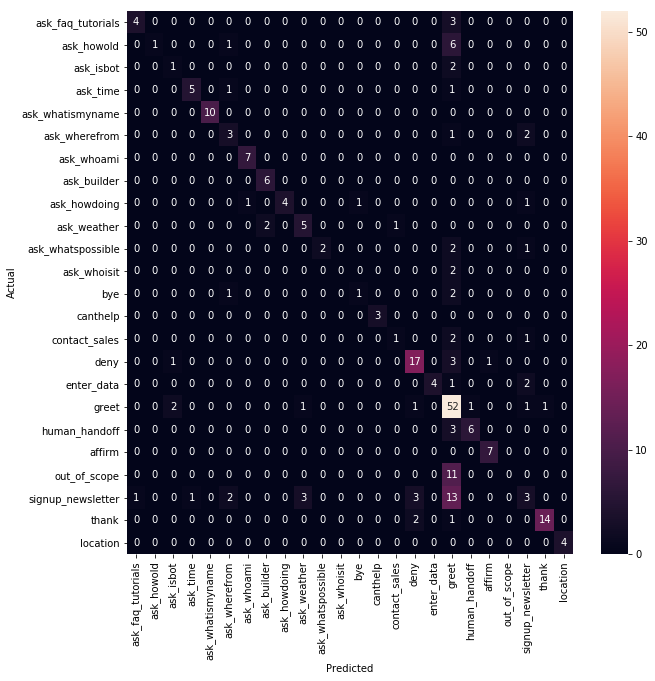

In [15]:
conf_mat  = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df['Intent'].unique(), yticklabels=df['Intent'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()